Part A: Probabilistic Gaussian Generative Classifier

Part B: Naïve Bayes 

Part C: Decision Trees

In [39]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
data= load_breast_cancer()
X = data.data
y = data.target
#we used stratify to maintain the same proportion of classes in each split
x_train, x_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3,stratify=y, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42) 


In [40]:
import numpy as np
from collections import Counter

class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf_node(self):
        return self.value is not None


In [ ]:
class DecisionTree:
    def __init__(self, min_samples_split=2, max_depth=None):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.root = None
        self.n_features = None
    # Fit the decision tree to the data
    def fit(self, X, y):
        self.root = self._grow_tree(X, y)

    def _grow_tree(self, X, y, depth=0):
        # Get number of samples and features
        n_samples, self.n_features = X.shape
        n_labels = len(np.unique(y))# number of unique labels(Benign, Malignant)


        if (n_labels == 1 or n_samples < self.min_samples_split or (self.max_depth is not None and depth >= self.max_depth)):
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        best_feature, best_thresh = self._best_split(X, y)

        if best_feature is None:
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)
        
        left_idxs, right_idxs = self._split(X[:, best_feature], best_thresh)

        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth + 1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth + 1)

        return Node(best_feature, best_thresh, left, right)

    def _best_split(self, X, y):
        best_gain = -1
        split_idx, split_threshold = None, None
        self.n_features = X.shape[1]

        for feat_idx in range(self.n_features):
            X_column = X[:, feat_idx]
            values = np.unique(X_column)
            values.sort()

            for i in range(len(values) - 1):
                threshold = (values[i] + values[i + 1]) / 2
                gain = self._information_gain(y, X_column, threshold)

                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_threshold = threshold

        return split_idx, split_threshold

    def _information_gain(self, y, X_column, threshold):
        parent_entropy = self._entropy(y)

        left_idxs, right_idxs = self._split(X_column, threshold)

        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0

        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)

        e_l = self._entropy(y[left_idxs])
        e_r = self._entropy(y[right_idxs])

        child_entropy = (n_l / n) * e_l + (n_r / n) * e_r
        return parent_entropy - child_entropy


    def _split(self, X_column, threshold):
        left_idxs = np.where(X_column <= threshold)[0]
        right_idxs = np.where(X_column > threshold)[0]
        return left_idxs, right_idxs


    def _entropy(self, y):
        hist = Counter(y)
        ps = [v / len(y) for v in hist.values()]
        return -sum(p * np.log2(p) for p in ps if p > 0)


    def _most_common_label(self, y):
        #return the most common label in y
        return Counter(y).most_common(1)[0][0]


    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value

        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)
    def feature_importances(self):
        importances = np.zeros(self.n_features)
    
        def traverse(node):
            if node is None or node.is_leaf_node():
                return
            importances[node.feature] += 1
            traverse(node.left)
            traverse(node.right)
    
        traverse(self.root)
        return importances / np.sum(importances)


In [42]:
tree = DecisionTree(max_depth=2, min_samples_split=2)
tree.fit(x_train, y_train)

In [43]:
y_train_pred = tree.predict(x_train)
train_acc = np.mean(y_train_pred == y_train)

print("Training Accuracy:", train_acc)

Training Accuracy: 0.9522613065326633


In [44]:
y_val_pred = tree.predict(x_val)
val_acc = np.mean(y_val_pred == y_val)

print("Validation Accuracy:", val_acc)


Validation Accuracy: 0.9176470588235294


In [45]:
y_test_pred = tree.predict(x_test)
test_accuracy = np.mean(y_test_pred == y_test)

print("Test Accuracy:", test_accuracy)

Test Accuracy: 0.8837209302325582


In [46]:
max_depth=[2,4,6,8,10]
min_samples_split=[2,5,10]
best_acc=0
best_params={}
results = []


for depth in max_depth:
    for min_samples in min_samples_split:
        tree = DecisionTree(max_depth=depth, min_samples_split=min_samples)
        tree.fit(x_train, y_train)

        y_val_pred = tree.predict(x_val)
        val_acc = np.mean(y_val_pred == y_val)
        results.append((depth, min_samples, val_acc))
        if val_acc>best_acc:
            best_acc=val_acc
            best_params={'max_depth':depth, 'min_samples_split':min_samples}
        print(f"Max Depth: {depth}, Min Samples Split: {min_samples}, Validation Accuracy: {val_acc}")
print("Best Validation Accuracy:", best_acc)
print("Best Hyperparameters:", best_params)

Max Depth: 2, Min Samples Split: 2, Validation Accuracy: 0.9176470588235294
Max Depth: 2, Min Samples Split: 5, Validation Accuracy: 0.9176470588235294
Max Depth: 2, Min Samples Split: 10, Validation Accuracy: 0.9176470588235294
Max Depth: 4, Min Samples Split: 2, Validation Accuracy: 0.9882352941176471
Max Depth: 4, Min Samples Split: 5, Validation Accuracy: 0.9882352941176471
Max Depth: 4, Min Samples Split: 10, Validation Accuracy: 0.9882352941176471
Max Depth: 6, Min Samples Split: 2, Validation Accuracy: 0.9647058823529412
Max Depth: 6, Min Samples Split: 5, Validation Accuracy: 0.9647058823529412
Max Depth: 6, Min Samples Split: 10, Validation Accuracy: 0.9647058823529412
Max Depth: 8, Min Samples Split: 2, Validation Accuracy: 0.9882352941176471
Max Depth: 8, Min Samples Split: 5, Validation Accuracy: 0.9647058823529412
Max Depth: 8, Min Samples Split: 10, Validation Accuracy: 0.9647058823529412
Max Depth: 10, Min Samples Split: 2, Validation Accuracy: 0.9882352941176471
Max Dep

In [47]:
X_train_val = np.vstack((x_train, x_val))
y_train_val = np.hstack((y_train, y_val))
final_tree = DecisionTree(max_depth=best_params['max_depth'], min_samples_split=best_params['min_samples_split'])

final_tree.fit(X_train_val, y_train_val)

In [48]:
y_test_pred = final_tree.predict(x_test)
test_accuracy = np.mean(y_test_pred == y_test)

print("Test Accuracy:", test_accuracy)

Test Accuracy: 0.8837209302325582


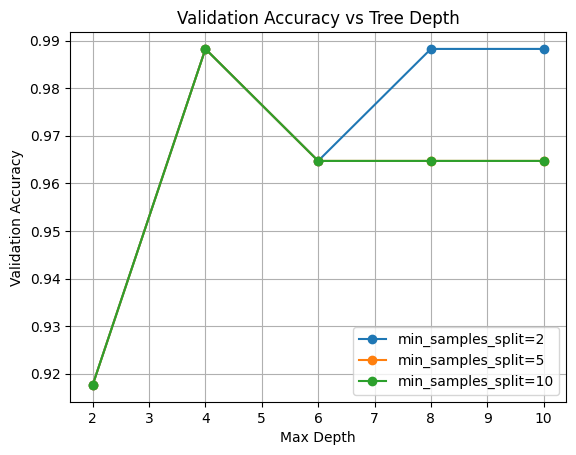

In [49]:
import matplotlib.pyplot as plt

for min_samples in min_samples_split:
    depths = [r[0] for r in results if r[1] == min_samples]
    accs = [r[2] for r in results if r[1] == min_samples]

    plt.plot(depths, accs, marker='o', label=f"min_samples_split={min_samples}")

plt.xlabel("Max Depth")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy vs Tree Depth")
plt.legend()
plt.grid(True)
plt.show()


In [50]:
fixed_min_samples = best_params['min_samples_split']
max_depths = [1, 2, 4, 6, 8, 10, 12]

train_accs = []
val_accs = []


In [51]:
for depth in max_depths:
    tree = DecisionTree(
        max_depth=depth,
        min_samples_split=fixed_min_samples
    )
    tree.fit(x_train, y_train)

    # Training accuracy
    y_train_pred = tree.predict(x_train)
    train_acc = np.mean(y_train_pred == y_train)

    # Validation accuracy
    y_val_pred = tree.predict(x_val)
    val_acc = np.mean(y_val_pred == y_val)

    train_accs.append(train_acc)
    val_accs.append(val_acc)


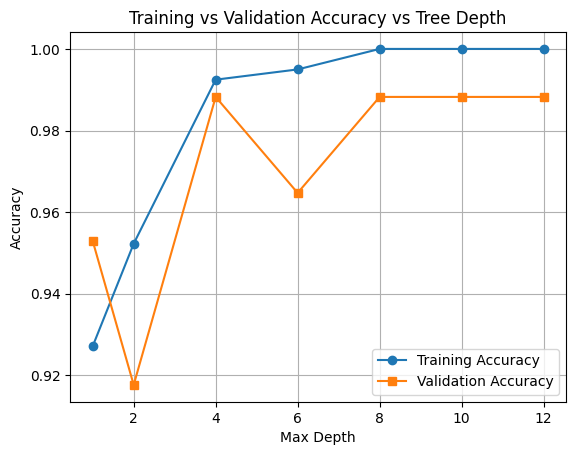

In [52]:
import matplotlib.pyplot as plt

plt.plot(max_depths, train_accs, marker='o', label='Training Accuracy')
plt.plot(max_depths, val_accs, marker='s', label='Validation Accuracy')

plt.xlabel("Max Depth")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy vs Tree Depth")
plt.legend()
plt.grid(True)
plt.show()


In [53]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_test_pred = final_tree.predict(x_test)

accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred, average=None)
recall = recall_score(y_test, y_test_pred, average=None)
f1 = f1_score(y_test, y_test_pred, average=None)

print("Accuracy:", accuracy)
print("Precision (Benign, Malignant):", precision)
print("Recall (Benign, Malignant):", recall)
print("F1-score (Benign, Malignant):", f1)


Accuracy: 0.8837209302325582
Precision (Benign, Malignant): [0.86666667 0.89285714]
Recall (Benign, Malignant): [0.8125     0.92592593]
F1-score (Benign, Malignant): [0.83870968 0.90909091]


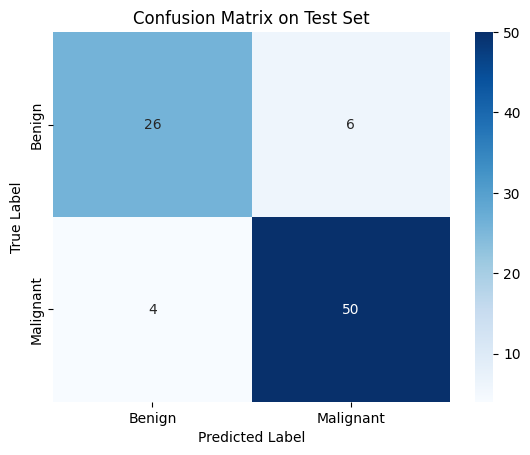

In [54]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_test_pred)

sns.heatmap(
    cm, annot=True, fmt="d",
    xticklabels=["Benign", "Malignant"],
    yticklabels=["Benign", "Malignant"],
    cmap="Blues"
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix on Test Set")
plt.show()


In [55]:
importances = final_tree.feature_importances()
feature_names = data.feature_names

sorted_idx = np.argsort(importances)[::-1]

for i in sorted_idx[:10]:
    print(f"{feature_names[i]}: {importances[i]:.3f}")


worst concave points: 0.182
worst radius: 0.182
worst texture: 0.182
worst perimeter: 0.091
worst area: 0.091
area error: 0.091
mean texture: 0.091
mean radius: 0.091
worst smoothness: 0.000
worst symmetry: 0.000


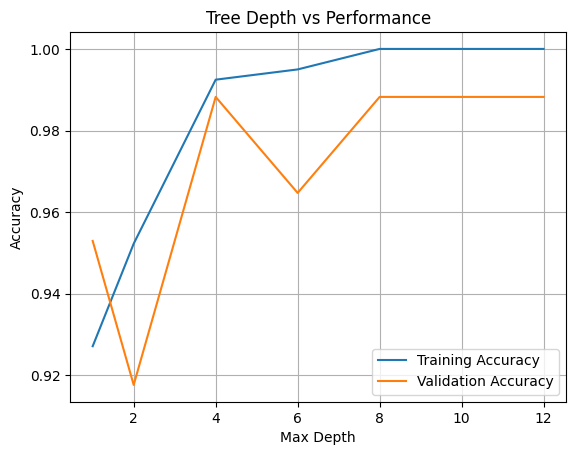

In [56]:
plt.plot(max_depths, train_accs, label="Training Accuracy")
plt.plot(max_depths, val_accs, label="Validation Accuracy")
plt.xlabel("Max Depth")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Tree Depth vs Performance")
plt.grid()
plt.show()


Part D: Random Forest